In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [ ]:
!nvidia-smi

In [ ]:
fig, axs = plt.subplots(ncols=3, sharex=True, figsize=(9, 3))

log1 = pd.read_csv('20200825_combined_losses/log.csv').set_index('epoch')
# log2 = pd.read_csv('20200819_new_gnn/log.csv').set_index('epoch')
# log3 = pd.read_csv('20200819_new_gnn_global_init/log.csv').set_index('epoch')
# log6 = pd.read_csv('20200819_new_gnn_global_init_dropout25_noln_adamW/log.csv').set_index('epoch')
log4 = pd.read_csv('20200819_new_gnn_global_init_adamW1E5/log.csv').set_index('epoch')


axs[0].plot(log1['loss'])
axs[0].plot(log1['val_loss'])

axs[1].plot(log1['spin_loss'])
axs[1].plot(log1['val_spin_loss'])

axs[2].plot(log1['bur_vol_loss'])
axs[2].plot(log1['val_bur_vol_loss'])

# plt.plot(log2)
#plt.plot(log3)
#plt.plot(log4)
#plt.plot(log5)
#plt.plot(log6)


for ax in axs:
    ax.set_yscale('log')
    
print(log1.min())

plt.tight_layout()
# plt.xlim([0, 10])

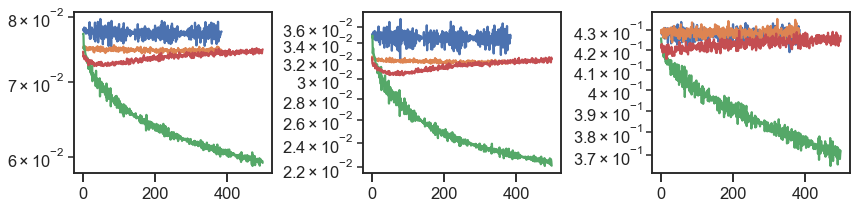

In [30]:
fig, axs = plt.subplots(ncols=3, sharex=True, figsize=(12, 3))

log = pd.read_csv('20200827_redox_transfer/log.csv').set_index('epoch')
log_r = pd.read_csv('20200827_redox_transfer_reduced/log.csv').set_index('epoch')
#log_rf = pd.read_csv('20200827_redox_transfer_reduced_frozen/log.csv').set_index('epoch')
log_rf7 = pd.read_csv('20200827_redox_transfer_reduced_frozen_lr7/log.csv').set_index('epoch')
log_rf = pd.read_csv('20200827_redox_transfer_reduced_frozenmodel/log.csv').set_index('epoch')


# axs[0].plot(log['loss'])
# axs[0].plot(log['val_loss'])

# axs[1].plot(log['spin_loss'])
# axs[1].plot(log['val_spin_loss'])

# axs[2].plot(log['bur_vol_loss'])
# axs[2].plot(log['val_bur_vol_loss'])

# axs[3].plot(log['redox_loss'])
# axs[3].plot(log['val_redox_loss'])

# axs[0].plot(log_r['loss'])
# axs[0].plot(log_r['val_loss'])

# axs[1].plot(log_r['spin_loss'])
# axs[1].plot(log_r['val_spin_loss'])

# axs[2].plot(log_r['bur_vol_loss'])
# axs[2].plot(log_r['val_bur_vol_loss'])

axs[0].plot(log_rf['loss'])
axs[0].plot(log_rf['val_loss'])

axs[1].plot(log_rf['spin_loss'])
axs[1].plot(log_rf['val_spin_loss'])

axs[2].plot(log_rf['bur_vol_loss'])
axs[2].plot(log_rf['val_bur_vol_loss'])

axs[0].plot(log_rf7['loss'])
axs[0].plot(log_rf7['val_loss'])

axs[1].plot(log_rf7['spin_loss'])
axs[1].plot(log_rf7['val_spin_loss'])

axs[2].plot(log_rf7['bur_vol_loss'])
axs[2].plot(log_rf7['val_bur_vol_loss'])


# plt.plot(log2)
#plt.plot(log3)
#plt.plot(log4)
#plt.plot(log5)
#plt.plot(log6)


for ax in axs:
    ax.set_yscale('log')
    
# print(log.min())

plt.tight_layout()
# plt.xlim([0, 10])

In [41]:
# log = pd.read_csv('20200831_just_redox/log.csv').set_index('epoch')
# plt.semilogy(log)

log = pd.read_csv('20200831_just_redox_xfer/log.csv').set_index('epoch')
plt.semilogy(log)

log = pd.read_csv('20200831_just_redox_xfer_frozen/log.csv').set_index('epoch')
plt.semilogy(log)

FileNotFoundError: [Errno 2] No such file or directory: '20200831_just_redox_xfer/log.csv'

In [33]:
log_r.min()

bur_vol_loss        0.193265
loss                0.032878
spin_loss           0.013547
val_bur_vol_loss    0.428545
val_loss            0.073172
val_spin_loss       0.030317
dtype: float64

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [2]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from layers import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20200825_combined_losses/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask,
                       'KLWithLogits': KLWithLogits,
                       'GlobalUpdate': GlobalUpdate,
                       'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate}})

# model.summary()

In [5]:
model.trainable = False

In [ ]:
global_state = GlobalUpdate(16, 8)([atom_state, bond_state, connectivity, global_state])
redox_pred = layers.Dense(2, name='redox')(global_state)

In [ ]:
from tensorflow.keras import layers

In [ ]:
tf.keras.layers

In [ ]:
global_state

In [ ]:
model.load_weights('20200825_combined_losses/best_model.hdf5')

In [ ]:
cdf = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
test = np.load('split.npz', allow_pickle=True)['test']

In [ ]:
cdf_test = cdf[cdf.smiles.isin(test)].copy()
cdf_test['fractional_spin'] = cdf_test.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())
cdf_test_pivot = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
cdf_test_pivot = cdf_test_pivot.reindex(test)
cdf_test_pivot.head()

In [ ]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test_pivot.shape[1]),  # explicit padding required for consistent output shape
                  padding_values=preprocessor.padding_values)

In [ ]:
predicted_fractional_spins = tf.nn.softmax(model.predict(test_dataset, verbose=True))

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(cdf_test_pivot.values.flatten(), predicted_fractional_spins.numpy().flatten(), '.', ms=.5)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')

In [ ]:
df_pred = pd.DataFrame(predicted_fractional_spins.numpy(), index=test).reset_index().melt(id_vars=['index']).rename(
    columns={'variable': 'atom_index', 'value': 'predicted_fractional_spin', 'index': 'smiles'})

cdf_test_merged = cdf_test.merge(df_pred, on=['smiles', 'atom_index'], how='left')
cdf_test_merged['abs_err'] = (cdf_test_merged['fractional_spin'] - cdf_test_merged['predicted_fractional_spin']).abs()

cdf_test_merged.groupby('atom_type').abs_err.mean().sort_values().plot.bar()
plt.ylabel('Fractional Spin MAE')

## Drawing outliers

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from IPython.display import SVG
from collections import defaultdict

pred_spin_df = cdf_test_merged.set_index(['smiles', 'atom_index'])

def draw(smiles, thres=0.25):

    mol = rdkit.Chem.MolFromSmiles(smiles)

    atomHighlights = defaultdict(list)

    colors = {'DFT':(1,0,0),
              'ML':(0,0,1),
              'rad':(0,1,0)
             }

    for atom in mol.GetAtoms():

        row = pred_spin_df.loc[smiles, atom.GetIdx()]
        if row.fractional_spin > thres:
            atomHighlights[atom.GetIdx()].append(colors['DFT'])

        if row.predicted_fractional_spin > thres:
            atomHighlights[atom.GetIdx()].append(colors['ML'])       

        if atom.GetNumRadicalElectrons() > 0:
            atomHighlights[atom.GetIdx()].append(colors['rad'])       


    d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
    dos = d2d.drawOptions()
    dos.atomHighlightsAreCircles = True
    dos.fillHighlights=False

    d2d.DrawMoleculeWithHighlights(mol,smiles,dict(atomHighlights),{},{},{})
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

In [ ]:
cdf_test_merged.sort_values('abs_err', ascending=False).drop_duplicates(subset='smiles', keep='first').head(10)

* Red: DFT
* Blue: ML
* Green: Formal radical center

In [ ]:
draw('Cc1nc(CC([O])=O)co1')

In [ ]:
draw('[O]C(=O)C[C@@H]1CO1')

Looks like there's some problem with carboxylic acid radicals. Let's pull all of them to see how we do on average

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
patt = Chem.MolFromSmarts('[OX1v1+0]C(=O)')  # https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html#RAD
unique_mols = pd.Series(cdf_test.smiles.unique())
is_carboxylic_acid = unique_mols.progress_apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(patt))

In [ ]:
matches = unique_mols[is_carboxylic_acid].progress_apply(lambda x: pd.Series(Chem.MolFromSmiles(x).GetSubstructMatch(patt)))
matches['smiles'] = unique_mols[is_carboxylic_acid]
matches = matches.melt(id_vars='smiles')[['smiles', 'value']].rename(columns={'value': 'atom_index'})
df = matches.merge(cdf_test_merged, on=['smiles', 'atom_index'])
odf = df[df.atom_type == 'O']

In [ ]:
len(unique_mols[is_carboxylic_acid])

In [ ]:
odf.fractional_spin.plot.hist()

In [ ]:
importsmilessycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:

    logdf = pd.read_sql_query("""
    SELECT * from unique_compound 
    where type='fragment' and status='finished'
    """, conn)
    

In [ ]:
cooh_logs = logdf[logdf.smiles.isin(unique_mols[is_carboxylic_acid])]

In [ ]:
import shutil

In [ ]:
import os

In [ ]:
for log in cooh_logs.logfile:
    shutil.copy(log, os.path.join('coo_logs', os.path.basename(log)))

In [ ]:
matches.melt()['value']

In [ ]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(cdf_subset.fractional_spin, cdf_subset.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Just [O]C(=O) Radicals')

Yup; not great here

In [ ]:
cdf_subset[cdf_subset.fractional_spin > .5].head(10)

Sometimes it ends up on the formal radical center...

In [ ]:
draw('C[C@]1(CC([O])=O)C[C@@]1(F)Cl')

In [ ]:
draw('C=CCCC(=C)C([O])=O')

In [ ]:
draw('CCC[C@H]1C[C@@H]1C([O])=O')

In [ ]:
formal_center = unique_mols.progress_apply(lambda x: [atom.GetIdx() for atom in Chem.MolFromSmiles(x).GetAtoms() if (atom.GetNumRadicalElectrons() == 1)][0])

In [ ]:
formal_center.name = 'atom_index'
radical_center_df = pd.DataFrame(formal_center)
radical_center_df['smiles'] = unique_mols

In [ ]:
preds_on_formal_center = radical_center_df.merge(cdf_test_merged, on=['smiles', 'atom_index'], how='left')

In [ ]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(preds_on_formal_center.fractional_spin, preds_on_formal_center.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Predictions on the formal radical center')

In [ ]:
# what about non carboxylic acid errors
cdf_test_merged[~cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])].sort_values(
    'abs_err', ascending=False).drop_duplicates(subset='smiles', keep='first').head(10)

This is a neat one

In [ ]:
draw('O=c1cnc2[c][nH]ccn1-2', thres=0.15)

What about what we're interested in, spin-delocalized radicals

In [ ]:
max_spin_by_mol = cdf_test_merged.groupby('smiles').fractional_spin.max()
max_spin_by_mol.plot.hist()

In [ ]:
delocalized = cdf_test_merged[cdf_test_merged.smiles.isin(max_spin_by_mol[max_spin_by_mol < 0.5].index)]

cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(delocalized.fractional_spin, delocalized.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Predictions on spin-delocalized radicals')

well, that's reassuring. Looks like we do decently here

In [ ]:
delocalized = cdf_test_merged[cdf_test_merged.smiles.isin(max_spin_by_mol[max_spin_by_mol < 0.25].index)]

cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(delocalized.fractional_spin, delocalized.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Predictions on super-delocalized radicals')

In [ ]:
patt = Chem.MolFromSmarts('[OX1v1+0]C=C')  # https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html#RAD
unique_mols = pd.Series(cdf_test.smiles.unique())
robs_radical1 = unique_mols.progress_apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(patt))

patt = Chem.MolFromSmarts('[CX3v3+0]C=O')  # https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html#RAD
robs_radical2 = unique_mols.progress_apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(patt))

In [ ]:
unique_mols[robs_radical2]

In [ ]:
draw('CC1=NC=C([O])C=CC1', thres=0.15)

In [ ]:
draw('C=C(C)[C@H](O)C(=C)[O]', thres=0.15)

In [ ]:
draw('C[C@@]12CCCC[C]1C(=O)C2', thres=0.15)

In [ ]:
len(unique_mols[robs_radical1 | robs_radical2])

In [ ]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[robs_radical1 | robs_radical2])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(cdf_subset.fractional_spin, cdf_subset.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')

In [ ]:
patt = Chem.MolFromSmarts('[OX1v1+0]C=C')
matches = unique_mols[robs_radical1].progress_apply(lambda x: pd.Series(Chem.MolFromSmiles(x).GetSubstructMatch(patt)))
matches['smiles'] = unique_mols[robs_radical1]

patt2 = Chem.MolFromSmarts('[CX3v3+0]C=O')
matches2 = unique_mols[robs_radical2].progress_apply(lambda x: pd.Series(Chem.MolFromSmiles(x).GetSubstructMatch(patt2)))
matches2['smiles'] = unique_mols[robs_radical2]

matches = matches.append(matches2)

matches = matches.drop(1, axis=1).melt(id_vars='smiles')[['smiles', 'value']].rename(columns={'value': 'atom_index'})
df = matches.merge(cdf_test_merged, on=['smiles', 'atom_index'])

In [ ]:
df[df.atom_type == 'O'].spin.plot.hist(range=(0,1), label='O')
df[df.atom_type == 'C'].spin.plot.hist(range=(0,1), label='C')
plt.legend(loc='upper center')